In [1]:
import sys
sys.path.append('../')
import canopus
from monodromy.render import _plot_coverage_set
from qiskit import QuantumCircuit
import pytket.qasm
from qiskit.transpiler import PassManager
import qiskit
import numpy as np

(CVXPY) Aug 06 06:21:47 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 06 06:21:47 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
cov = canopus.utils.get_stabilizer_isa_coverage()

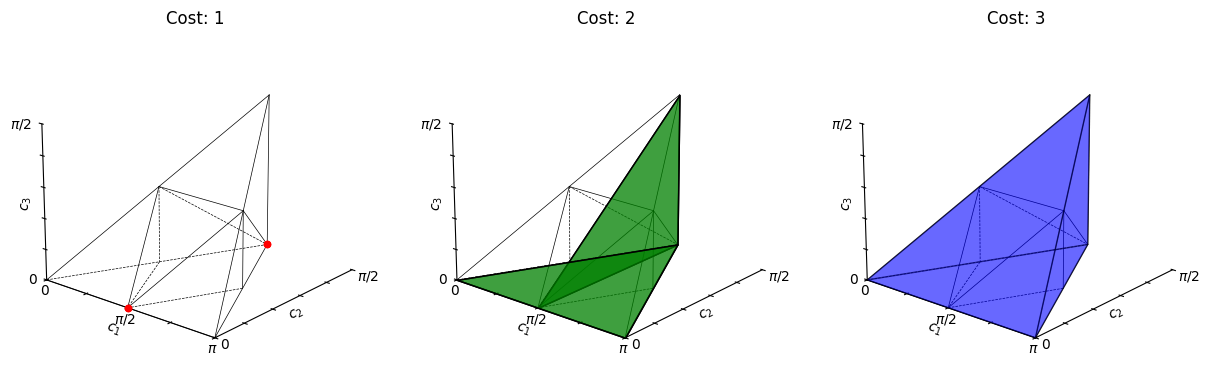

In [3]:
_plot_coverage_set(cov)

In [4]:
# qasm_fname = './qldpc_circ/gb_code/GBCode_[[18, 2, 5]]_Naive_CX.qasm'
qasm_fname = './qldpc_circ/steane_code/SteaneCode_[[7, 1, 3]]_Naive_CX.qasm'
qc = QuantumCircuit.from_qasm_file(qasm_fname)

# 此处考虑两种ISA: {CX, U3}; {CX, iSWAP, U3}
cx_cost_est = canopus.SynthCostEstimator('cx') # cx means {CX, U3} ISA
stab_isa_cost_est = canopus.SynthCostEstimator('stab') # stab means {CX, iSWAP, U3} ISA

In [5]:
print("cx   cost = ", cx_cost_est.eval_circuit_cost(qc))
print("stab cost = ", stab_isa_cost_est.eval_circuit_cost(qc))

cx   cost =  7.0
stab cost =  7.0


In [6]:
qc = canopus.rebase_to_tk2(qc)

In [7]:
def canopus_pass(qc, topology, isa):
    if topology == "chain":
        coupling_map = canopus.utils.gene_chain_coupling_map(qc.num_qubits)
    elif topology == "hhex":
        coupling_map = canopus.utils.gene_hhex_coupling_map(qc.num_qubits)
    elif topology == "square":
        coupling_map = canopus.utils.gene_square_coupling_map(qc.num_qubits)
    else:
        raise ValueError(f"Unsupported topology: {topology}")
    
    backend = canopus.CanopusBackend(coupling_map, isa)
    qc_mapped = PassManager(canopus.CanopusMapping(backend)).run(qc)
    return qc_mapped

def sabre_pass(qc, topology):
    if topology == "chain":
        coupling_map = canopus.utils.gene_chain_coupling_map(qc.num_qubits)
    elif topology == "hhex":
        coupling_map = canopus.utils.gene_hhex_coupling_map(qc.num_qubits)
    elif topology == "square":
        coupling_map = canopus.utils.gene_square_coupling_map(qc.num_qubits)
    else:
        raise ValueError(f"Unsupported topology: {topology}")
    
    backend = canopus.CanopusBackend(coupling_map)
    qc_mapped = PassManager(canopus.SabreMapping(backend)).run(qc)
    return qc_mapped

In [8]:
np.random.seed(123)

In [9]:
qc_sabre = sabre_pass(qc, "square")
qc_sabre_rebase_tk2 = canopus.rebase_to_tk2(qc_sabre)

In [10]:
cx_cost_est.eval_circuit_cost(qc_sabre_rebase_tk2), stab_isa_cost_est.eval_circuit_cost(qc_sabre_rebase_tk2)

(26.0, 20.0)

In [11]:
# Routing by Canopus
qc_canopus_cx = canopus_pass(qc, "square", 'cx')
qc_canopus_stab = canopus_pass(qc, "square", 'stab')

In [12]:
initial_layout = qc_canopus_stab.layout.initial_layout
final_layout = qc_canopus_stab.layout.final_layout
print(initial_layout)

# print(initial_layout.get_virtual_bits())
for q,p in initial_layout.get_virtual_bits().items():
    global_index = qc_canopus_stab.qubits.index(q)
    print(f"Qubit {global_index} is mapped to physical qubit {p}")

Layout({
1: Qubit(QuantumRegister(13, 'q'), 0),
8: Qubit(QuantumRegister(13, 'q'), 1),
6: Qubit(QuantumRegister(13, 'q'), 2),
12: Qubit(QuantumRegister(13, 'q'), 3),
9: Qubit(QuantumRegister(13, 'q'), 4),
10: Qubit(QuantumRegister(13, 'q'), 5),
5: Qubit(QuantumRegister(13, 'q'), 6),
3: Qubit(QuantumRegister(13, 'q'), 7),
7: Qubit(QuantumRegister(13, 'q'), 8),
0: Qubit(QuantumRegister(13, 'q'), 9),
2: Qubit(QuantumRegister(13, 'q'), 10),
4: Qubit(QuantumRegister(13, 'q'), 11),
11: Qubit(QuantumRegister(13, 'q'), 12)
})
Qubit 0 is mapped to physical qubit 1
Qubit 1 is mapped to physical qubit 8
Qubit 2 is mapped to physical qubit 6
Qubit 3 is mapped to physical qubit 12
Qubit 4 is mapped to physical qubit 9
Qubit 5 is mapped to physical qubit 10
Qubit 6 is mapped to physical qubit 5
Qubit 7 is mapped to physical qubit 3
Qubit 8 is mapped to physical qubit 7
Qubit 9 is mapped to physical qubit 0
Qubit 10 is mapped to physical qubit 2
Qubit 11 is mapped to physical qubit 4
Qubit 12 is mapp

In [14]:
def get_layout(qc):
    ''' Returns the initial and final layout of the quantum circuit.'''
    initial_layout = qc.layout.initial_layout
    final_layout = qc.layout.final_layout
    log_to_phys_initial = {qc.qubits.index(q): p for q, p in initial_layout.get_virtual_bits().items()}
    log_to_phys_final = {qc.qubits.index(q): p for q, p in final_layout.get_virtual_bits().items()}
    return log_to_phys_initial, log_to_phys_final

# qc_canopus_stab.draw(fold=10000)
# print("Debug [Kai] 1-initial:", qc_canopus_stab.layout.initial_layout)
# print("Debug [Kai] 1-final  :", qc_canopus_stab.layout.final_layout)

log_to_phys_initial, log_to_phys_final = get_layout(qc_canopus_stab)
print("Debug [Kai] 2-initial:", log_to_phys_initial)
print("Debug [Kai] 2-final  :", log_to_phys_final)
# 以下是为了合并所有的 2Q 门到 Canonical 形式 
qc_canopus_cx_rebase_tk2 = canopus.rebase_to_tk2(qc_canopus_cx)
# print("Debug [Kai] 2:", qc_canopus_cx.layout.initial_layout)
qc_canopus_stab_rebase_tk2 = canopus.rebase_to_tk2(qc_canopus_stab)

Debug [Kai] 2-initial: {0: 1, 1: 8, 2: 6, 3: 12, 4: 9, 5: 10, 6: 5, 7: 3, 8: 7, 9: 0, 10: 2, 11: 4, 12: 11}
Debug [Kai] 2-final  : {0: 9, 1: 2, 2: 5, 3: 6, 4: 8, 5: 11, 6: 0, 7: 4, 8: 12, 9: 1, 10: 10, 11: 3, 12: 7}


In [15]:
qc_canopus_stab.draw(fold=10000)

┌───────────────────┐┌───────────────┐ ┌──────────────┐                                                                                                                                                                                                                                                                                                                    
  q_9 -> 0 ┤ U(3π/2,-π/2,3π/2) ├┤0              ├─┤ U(π/2,0,π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X─────────X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           └───────────────────┘│  Can(0.5,0,0) │┌┴──────────────┤                                                                                     ┌───────────────┐┌────────────┐ │         │        ┌───────────────┐┌────────────┐                                                      ┌───────────────┐                                                                      
  q_0 -> 1 ─────────────────────┤1              ├┤0              ├────────X────────────────────────────────────────────────────────────────────────────┤0              ├┤ U(π/2,0,π) ├─X─────────┼────────┤0              ├┤ U(π/2,0,π) ├─────────────────────────X────────────────────────────┤0              ├────────X─────────────────────────────────────────────────────────────
             ┌────────────────┐ └───────────────┘│  Can(0.5,0,0) │        │                         ┌───────────────┐                                  │               │└────────────┘           │        │               │└────────────┘┌───────────────┐        │                            │  Can(0.5,0,0) │        │                                                             
 q_10 -> 2 ──┤ U(π,-π/2,7π/2) ├──────────────────┤1              ├────────X─────────────────────────┤0              ├──────────────────────────────────┤               ├─────────────────────────┼────────┤               ├──────X───────┤0              ├────────┼──────────────────────────X─┤1              ├────────┼────────────────X────────────────────────────────────────────
           ┌─┴────────────────┴┐                 ├───────────────┤ ┌──────────────┐                 │  Can(0.5,0,0) │                                  │               │                         │        │               │      │       │  Can(0.5,0,0) │        │          ┌────────────┐  │ └───────────────┘        │                │        ┌───────────────┐   ┌────────────┐  
  q_7 -> 3 ┤ U(3π/2,-π/2,3π/2) ├─────────────────┤0              ├─┤ U(π/2,0,π/2) ├────────X────────┤1              ├──────────────────────────────────┤               ├─────────────────────────┼────────┤               ├──────┼───────┤1              ├────────┼──────────┤ U(π/2,0,π) ├──X──────────────────────────┼────────────────X────────┤0              ├───┤ U(π/2,0,π) ├──
           └─┬────────────────┬┘                 │               │ └──────────────┘        │        └───────────────┘                 ┌───────────────┐│  Can(0.5,0,0) │┌────────────┐           │        │  Can(0.5,0,0) │      │       └───────────────┘        │          └────────────┘                             │                         │               │   └────────────┘  
 q_11 -> 4 ──┤ U(π,-π/2,7π/2) ├──────────────────┤               ├─────────────────────────X──────────────────────────────────────────┤0              ├┤               ├┤ U(π/2,0,π) ├───────────┼────────┤               ├──────┼────────────────────────────────┼─────────────────────────────────────────────────────┼─────────────────────────┤               ├───────────────────
           ┌─┴────────────────┴┐┌───────────────┐│               │ ┌──────────────┐                 ┌───────────────┐  ┌────────────┐ │               ││               │└────────────┘           │        │               │      │       ┌───────────────┐        │  

In [19]:
cx_cost_est.eval_circuit_cost(qc_canopus_cx_rebase_tk2), stab_isa_cost_est.eval_circuit_cost(qc_canopus_stab_rebase_tk2)

(22.0, 15.0)

接下来将{Can,U3}转换为 Clifford2Q and Clifford1Q

In [28]:
qc_sabre_pre_stim = canopus.synthesis.synthesize_clifford_circuit(qc_sabre_rebase_tk2)
qc_canopus_cx_pre_stim = canopus.synthesis.synthesize_clifford_circuit(qc_canopus_cx_rebase_tk2)
qc_canopus_stab_pre_stim = canopus.synthesis.synthesize_clifford_circuit(qc_canopus_stab_rebase_tk2, isa='stab')

In [29]:
cx_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qc_canopus_cx_rebase_tk2)), stab_isa_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qc_canopus_stab_rebase_tk2))

(22.0, 15.0)

In [43]:
print("Sabre:", qc_sabre_pre_stim.count_ops())
print("Canopus CX:", qc_canopus_cx_pre_stim.count_ops())
print("Canopus Stab:", qc_canopus_stab_pre_stim.count_ops())

Sabre: OrderedDict([('sx', 57), ('cx', 51), ('s', 34), ('z', 33), ('sdg', 27)])
Canopus CX: OrderedDict([('sx', 65), ('cx', 51), ('z', 37), ('sdg', 35), ('s', 28)])
Canopus Stab: OrderedDict([('sx', 74), ('s', 59), ('sdg', 49), ('cx', 35), ('z', 29), ('iswap', 15)])


In [31]:
from qiskit.qasm2 import dumps
print(type(qc_sabre_pre_stim))
qasm_str = dumps(qc_sabre_pre_stim)
print(qasm_str)

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
OPENQASM 2.0;
include "qelib1.inc";
qreg q[13];
sdg q[1];
sx q[1];
sx q[2];
sx q[2];
sx q[3];
z q[3];
sdg q[4];
sx q[4];
sdg q[4];
cx q[4],q[3];
sdg q[3];
sx q[3];
cx q[3],q[2];
z q[2];
z q[3];
sx q[3];
sdg q[3];
z q[4];
s q[5];
sx q[5];
cx q[5],q[0];
sdg q[0];
sx q[0];
sdg q[0];
cx q[1],q[0];
sdg q[0];
sx q[0];
s q[0];
z q[1];
sx q[1];
sdg q[1];
z q[5];
sx q[5];
sdg q[5];
sdg q[6];
sx q[6];
z q[6];
cx q[6],q[5];
z q[5];
sx q[5];
z q[5];
s q[6];
sx q[6];
s q[6];
sx q[7];
z q[8];
sdg q[9];
sx q[9];
cx q[9],q[4];
sdg q[4];
sx q[4];
s q[4];
s q[9];
sx q[9];
s q[9];
sdg q[10];
sx q[10];
z q[10];
cx q[10],q[5];
z q[5];
sx q[5];
z q[5];
s q[10];
sx q[10];
s q[10];
s q[12];
sx q[12];
cx q[12],q[11];
sdg q[12];
cx q[12],q[7];
z q[7];
cx q[8],q[7];
cx q[7],q[8];
cx q[8],q[7];
cx q[7],q[6];
cx q[6],q[7];
cx q[7],q[6];
sx q[6];
z q[6];
cx q[7],q[2];
cx q[2],q[7];
cx q[7],q[2];
sx q[2];
z q[2];
sx q[7];
z q[7];
s q[8];
sx q[8];
cx q[8],q[3];
s

In [32]:
qc_sabre_pre_stim.draw(fold=10000)

global phase: 7π/4
                           ┌───┐ ┌─────┐ ┌────┐┌─────┐┌───┐┌─────┐┌────┐ ┌───┐                                                                                                                                                                                                                                                                                                                      
 q_0: ─────────────────────┤ X ├─┤ Sdg ├─┤ √X ├┤ Sdg ├┤ X ├┤ Sdg ├┤ √X ├─┤ S ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ┌─────┐┌────┐        └─┬─┘ └─────┘ └────┘└─────┘└─┬─┘└┬───┬┘├────┤┌┴───┴┐                                                                                  ┌───┐  ┌───┐ ┌────┐┌───┐                                                                                                                                                         ┌───┐┌───┐  ┌────┐ ┌───┐ ┌───┐                    
 q_1: ┤ Sdg ├┤ √X ├──────────┼──────────────────────────■───┤ Z ├─┤ √X ├┤ Sdg ├──────────────────────────────────────────────────────────────────────────────────┤ X ├──┤ Z ├─┤ √X ├┤ Z ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Z ├──┤ √X ├─┤ Z ├─┤ X ├────────────────────
      └┬────┤├────┤          │                        ┌───┐ ├───┤ └────┘└─────┘                                        ┌───┐          ┌───┐┌────┐┌───┐ ┌───┐┌───┐└─┬─┘  ├───┤ ├────┤├───┤                                                                                                                         ┌───┐                ┌───┐┌───┐ └─┬─┘├───┴┐ └────┘ └───┘ └─┬─┘                    
 q_2: ─┤ √X ├┤ √X ├──────────┼────────────────────────┤ X ├─┤ Z ├──────────────────────────────────────────────────────┤ X ├───────■──┤ X ├┤ √X ├┤ Z ├─┤ X ├┤ S ├──■────┤ S ├─┤ √X ├┤ S ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────■────────┤ X ├┤ S ├───┼──┤ √X ├────────────────■──────────────────────
       ├────┤├───┬┘          │    ┌───┐ ┌─────┐ ┌────┐└─┬─┘ ├───┤ ┌────┐┌─────┐                      ┌───┐┌─────┐┌────┐└─┬─┘       │  └─┬─┘└────┘└───┘ └─┬─┘├───┤┌────┐ ├───┤ └────┘└───┘                                                                                                                         └─┬─┘       │        └─┬─┘└───┘   │  └────┘                                       
 q_3: ─┤ √X ├┤ Z ├───────────┼────┤ X ├─┤ Sdg ├─┤ √X ├──■───┤ Z ├─┤ √X ├┤ Sdg ├──────────────────────┤ X ├┤ Sdg ├┤ √X ├──┼─────────┼────┼────────────────■──┤ S ├┤ √X ├─┤ S ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┼──────────┼──────────┼───────────────────────────────────────────────
      ┌┴────┤├───┴┐┌─────┐   │    └─┬─┘ └┬───┬┘ └────┘┌───┐┌┴───┴┐├────┤└┬───┬┘                      └─┬─┘└─────┘└────┘  │         │    │                   └───┘└────┘ └───┘                                                                                                                                       │         │          │          │                                               
 q_4: ┤ Sdg ├┤ √X ├┤ Sdg ├───┼──────■────┤ Z ├────────┤ X ├┤ Sdg ├┤ √X ├─┤ S ├─────────────────────────┼─────────────────┼─────────┼────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┼──────────┼──────────┼───────────────────────────────────────────────
      └┬───┬┘├────┤└─────┘   │    ┌───┐  ├───┴┐┌─────┐└─┬─┘└┬───┬┘├───┬┘ ├───┴┐┌───┐ ┌───┐┌

In [41]:
from qiskit import transpile
# qc_sabre_rebase_tk2.layers()
qc_canopus_stab_pre_stim.depth()
# scheduled_circ = transpile(qc_sabre_pre_stim, scheduling_method='asap')  # or 'asap'
# print(scheduled_circ.qasm()) 

47

In [58]:
qasm_str_canopus = dumps(qc_canopus_stab_pre_stim)
print(qasm_str_canopus)

OPENQASM 2.0;
include "qelib1.inc";
gate iswap q0,q1 { s q0; s q1; h q0; cx q0,q1; cx q1,q0; h q1; }
qreg q[13];
z q[0];
sx q[1];
sx q[1];
sx q[2];
z q[2];
sdg q[3];
sx q[3];
sdg q[3];
cx q[3],q[2];
sdg q[2];
sx q[2];
cx q[2],q[1];
z q[1];
sdg q[2];
z q[3];
sx q[3];
z q[3];
sx q[4];
z q[5];
sx q[5];
z q[5];
sx q[6];
z q[7];
sx q[7];
z q[7];
s q[8];
sx q[8];
z q[8];
s q[9];
sx q[9];
sdg q[9];
iswap q[9],q[8];
z q[8];
sx q[8];
s q[8];
cx q[8],q[7];
z q[7];
cx q[9],q[4];
s q[4];
sx q[4];
z q[4];
s q[9];
sx q[9];
s q[9];
cx q[9],q[8];
s q[8];
sx q[8];
sdg q[9];
iswap q[9],q[8];
cx q[8],q[7];
s q[7];
sx q[7];
sdg q[8];
iswap q[8],q[7];
sx q[7];
z q[7];
sdg q[8];
s q[9];
sx q[9];
s q[9];
s q[11];
sx q[11];
cx q[11],q[10];
cx q[10],q[5];
sdg q[5];
sx q[5];
sdg q[11];
cx q[11],q[6];
z q[6];
cx q[6],q[1];
s q[1];
sx q[1];
sdg q[6];
iswap q[6],q[1];
sx q[1];
z q[1];
cx q[2],q[1];
sdg q[1];
sx q[1];
s q[1];
cx q[1],q[0];
s q[0];
sx q[0];
sdg q[1];
iswap q[1],q[0];
sx q[0];
z q[0];
z q[1];
sx q[1]

In [ ]:
qc_sabre_pre_stim.draw(fold=10000)

global phase: π/2
       ┌───┐ ┌────┐ ┌───┐                        ┌───┐┌───┐                                                                                                                                                                                                                                             
 q_0: ─┤ Z ├─┤ √X ├─┤ Z ├────────────────────────┤ X ├┤ Z ├──X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ┌┴───┴┐├────┤┌┴───┴┐     ┌───┐┌────┐┌─────┐└─┬─┘└───┘  │    ┌────┐┌───┐                                                                                                                                       ┌───┐┌───┐┌────┐┌───┐┌───┐┌───┐                                                     
 q_1: ┤ Sdg ├┤ √X ├┤ Sdg ├──■──┤ S ├┤ √X ├┤ Sdg ├──■─────────X────┤ √X ├┤ Z ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Z ├┤ √X ├┤ Z ├┤ X ├┤ Z ├─X───X───────────────────────────────────────────────
      └┬────┤├───┬┘└─────┘┌─┴─┐├───┤├────┤└┬───┬┘┌───┐┌───┐┌────┐ ├───┬┘└───┘                      ┌───┐┌───┐      ┌───┐ ┌────┐     ┌─────┐                                                                         └─┬─┘└───┘└────┘└───┘└─┬─┘└───┘ │   │   ┌───┐┌────┐     ┌─────┐                     
 q_2: ─┤ √X ├┤ Z ├────────┤ X ├┤ Z ├┤ √X ├─┤ Z ├─┤ X ├┤ Z ├┤ √X ├─┤ Z ├────────────────────────────┤ X ├┤ Z ├──X───┤ S ├─┤ √X ├──■──┤ Sdg ├───────────────────────────────────────────────────────────────────────────┼────────────────────■────────┼───X───┤ S ├┤ √X ├──■──┤ Sdg ├────────■────────────
       ├───┬┘├───┴┐ ┌───┐ └───┘└───┘└────┘ └───┘ └─┬─┘├───┤├───┬┘ ├───┴┐┌───┐                      └─┬─┘└───┘  │   └───┘ └────┘┌─┴─┐└┬───┬┘┌────┐┌───┐                                                                │                             │       └───┘└────┘┌─┴─┐└┬───┬┘┌────┐  │  ┌───┐┌───┐
 q_3: ─┤ Z ├─┤ √X ├─┤ Z ├──────────────────────────┼──┤ X ├┤ Z ├──┤ √X ├┤ Z ├────────────────────────┼─────────┼───────────────┤ X ├─┤ Z ├─┤ √X ├┤ Z ├────────────────────────────────────────────────────────────────┼─────────────────────────────┼──────────────────┤ X ├─┤ Z ├─┤ √X ├──┼──┤ Z ├┤ X ├
      ┌┴───┴┐├────┤┌┴───┴┐     ┌───┐┌────┐┌─────┐  │  └─┬─┘└───┘  └────┘└───┘                        │         │               └───┘ └───┘ └────┘└───┘                                                                │                             │                  └───┘ └───┘ └────┘  │  └───┘└─┬─┘
 q_4: ┤ Sdg ├┤ √X ├┤ Sdg ├──■──┤ S ├┤ √X ├┤ Sdg ├──┼────■────────────────────────────────────────────┼─────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────┼──────────────────────────────────────┼─────────┼──
      └┬───┬┘├────┤└┬───┬┘  │  └───┘└────┘└─────┘  │  ┌───┐┌───┐  ┌────┐┌───┐                        │         │                                 ┌───┐┌───┐                ┌───┐ ┌────┐                               │                             │                                      │         │  
 q_5: ─┤ Z ├─┤ √X ├─┤ Z ├───┼──────────────────────┼──┤ X ├┤ Z ├──┤ √X ├┤ Z ├────────────────────────┼─────────┼─────────────────────────────────┤ X ├┤ Z ├─────────────X──┤ S ├─┤ √X ├───────────────────────────────┼─────────────────────────────┼──────────────■───────────────────────┼─────────┼──
      ┌┴───┴┐├────┤ ├───┤   │                      │  └─┬─┘└───┘ ┌┴────┤└───┘                        │         │                     ┌───┐ ┌────┐└─┬─┘├───┤┌────┐┌───┐  │  └───┘ ├───┬┘┌────┐     ┌───┐ ┌────┐┌───┐   │  ┌───┐┌────┐┌───┐           │ ┌────┐┌───┐┌─┴─┐                     │         │  
 q_6: ┤ Sdg ├┤ √X ├─┤ Z ├───┼──────────────────────┼────┼────■───┤ Sdg ├─────────────────────────────┼─────────┼─────────

In [86]:
import stim

stim_circ = stim.Circuit()

qc_pre_stim = qc_canopus_stab_pre_stim # 选择要转换的量子线路
num_qubits = qc_pre_stim.num_qubits    # 量子线路 qc_pre_stim 里面的量子比特数量
num_clbits = qc_pre_stim.num_clbits    # 量子线路 qc_pre_stim 里面的经典比特数量
# print(num_qubits, num_clbits)

stim_circ.append("R", [i for i in range(num_qubits)])
for instruction in qc_pre_stim.data:
    gate = instruction.operation
    qubit_indices = [qc_pre_stim.qubits.index(q) for q in instruction.qubits]
    # classical bits if needed: instruction.clbits

    name = gate.name.lower()

    if name == 'h':
        stim_circ.append("H", [qubit_indices[0]])
    elif name in ('cx', 'cnot'):
        stim_circ.append("CNOT", [qubit_indices[0], qubit_indices[1]])
    elif name == 'cz':
        stim_circ.append("CZ", [qubit_indices[0], qubit_indices[1]])
    elif name == 's':
        stim_circ.append("S", [qubit_indices[0]])
    elif name in ('sdg', 's_dag', 'sdag'):
        stim_circ.append("S_DAG", [qubit_indices[0]])
    elif name == 'x':
        stim_circ.append("X", [qubit_indices[0]])
    elif name in ('sx', 'sqrtx'):
        stim_circ.append("SQRT_X", [qubit_indices[0]])
    elif name == 'y':
        stim_circ.append("Y", [qubit_indices[0]])
    elif name in ('sy', 'sqrty'):
        stim_circ.append("SQRT_Y", [qubit_indices[0]])
    elif name == 'z':
        stim_circ.append("Z", [qubit_indices[0]])
    elif name in ('sz', 'sqrtz'):
        stim_circ.append("SQRT_Z", [qubit_indices[0]])
    elif name == 'swap':
        stim_circ.append("SWAP", [qubit_indices[0], qubit_indices[1]])
    elif name == 'iswap':
        stim_circ.append("ISWAP", [qubit_indices[0], qubit_indices[1]])
    elif name == 'measure':
        stim_circ.append("M", [qubit_indices[0]])
    else:
        raise ValueError(f"Unsupported gate: {gate.name}")
    
# random measurement test
stim_circ.append("M", [i for i in range(10)])
print(stim_circ)

R 0 1 2 3 4 5 6 7 8 9 10 11 12
Z 0
SQRT_X 1 1 2
Z 2
S_DAG 3
SQRT_X 3
S_DAG 3
CX 3 2
S_DAG 2
SQRT_X 2
CX 2 1
Z 1
S_DAG 2
Z 3
SQRT_X 3
Z 3
SQRT_X 4
Z 5
SQRT_X 5
Z 5
SQRT_X 6
Z 7
SQRT_X 7
Z 7
S 8
SQRT_X 8
Z 8
S 9
SQRT_X 9
S_DAG 9
ISWAP 9 8
Z 8
SQRT_X 8
S 8
CX 8 7
Z 7
CX 9 4
S 4
SQRT_X 4
Z 4
S 9
SQRT_X 9
S 9
CX 9 8
S 8
SQRT_X 8
S_DAG 9
ISWAP 9 8
CX 8 7
S 7
SQRT_X 7
S_DAG 8
ISWAP 8 7
SQRT_X 7
Z 7
S_DAG 8
S 9
SQRT_X 9
S 9 11
SQRT_X 11
CX 11 10 10 5
S_DAG 5
SQRT_X 5
S_DAG 11
CX 11 6
Z 6
CX 6 1
S 1
SQRT_X 1
S_DAG 6
ISWAP 6 1
SQRT_X 1
Z 1
CX 2 1
S_DAG 1
SQRT_X 1
S 1
CX 1 0
S 0
SQRT_X 0
S_DAG 1
ISWAP 1 0
SQRT_X 0
Z 0 1
SQRT_X 1
S_DAG 1
S 2
SQRT_X 2
S 2
CX 3 2
S 2
SQRT_X 2
S_DAG 3
ISWAP 3 2
S 2
SQRT_X 2
CX 2 1
Z 1
SQRT_X 1
Z 1
S 3
ISWAP 4 3
S_DAG 3
SQRT_X 3
Z 4
SQRT_X 4
S 4
CX 5 0
Z 0
SQRT_X 0
Z 0 5
SQRT_X 5
S_DAG 5
Z 6
SQRT_X 6
S_DAG 6
CX 8 3
Z 3
CX 3 2
S 2
SQRT_X 2
S_DAG 3
ISWAP 3 2
S 2
SQRT_X 2
S 3
SQRT_X 3
S 3
S_DAG 8 11
CX 11 6
Z 6
SQRT_X 6
Z 6 11
SQRT_X 11
S_DAG 11 12
SQRT_X 12
Z 12
CX 12 7

In [85]:
sampler = stim_circ.compile_sampler()
syndrome_matrix = sampler.sample(shots=100)  # shape: (100, num_measurements)
print(syndrome_matrix)
# syndrome_matrix, actual_observables = sampler.sample(shots=100, separate_observables=True)
# print(syndrome_matrix, actual_observables)
print(stim_circ)

[[ True False False  True False False  True False False  True]
 [ True False False False  True False  True  True False False]
 [ True False False False False False  True  True False False]
 [ True False  True False  True False False False False  True]
 [ True False False False False False  True  True False False]
 [ True False False  True False False  True False False  True]
 [False False  True  True False False  True False False False]
 [ True False False  True False False  True False False  True]
 [False False  True False  True False  True  True False  True]
 [False False  True False False False  True  True False  True]
 [ True False  True False False False False False False  True]
 [ True False False False  True False  True  True False False]
 [ True False False  True False False  True False False  True]
 [ True False  True False  True False False False False  True]
 [ True False  True  True False False False  True False False]
 [False False  True False  True False  True  True False